## TrainStats - Morelli Giovanni

#### Progetto Laboratorio di Big Data, Data Mining e Data Analytics
CdL Tecnologie dei Sistemi Informatici | AA 2025-2026


### Descrizione del progetto

Questo progetto di Big Data Analytics analizza le performance della rete ferroviaria italiana nel mese di Novembre 2025, utilizzando dati reali granulari estratti dalla piattaforma TrainStats.

2 obiettivi principali:
- Capire i dati (Analisi): Scoprire dove si bloccano i treni, quali sono le tratte peggiori e in quali orari si verificano più spesso i problemi.

- Fare previsioni (Machine Learning): Creare un sistema intelligente che provi a indovinare in anticipo quanto ritardo farà un treno e quanto sarà grave il problema, anche se il traffico ferroviario è molto imprevedibile.


---

### Dataset

Il dataset copre il traffico nazionale dal 01/11/2025 al 30/11/2025.

- Volume: ~250.000 corse monitorate.
- Granularità: Dati per singolo treno (non aggregati).
- Scope: Sono stati filtrati i treni internazionali e i convogli tecnici/merci per focalizzare l'analisi sull'esperienza passeggeri.

---

### Pipeline

Il progetto segue tre passaggi logici:

#### 1. Pulizia e Preparazione Dati
Ho "ripulito" il dataset eliminando i treni esteri. Inoltre, ho creato nuove informazioni utili, calcolando ad esempio quanto ritardo si accumula *durante* il viaggio e dividendo i ritardi in fasce di gravità per semplificare l'analisi.

#### 2. Le Scoperte Principali (Insight)
* **Il caso dei Regionali:** L'analisi mostra che, anche se i treni Regionali sono numerosissimi, sono in media più puntuali. Al contrario, Frecce ed Eurocity soffrono di ritardi maggiori perché percorrono tragitti lunghi esposti a più imprevisti.
* **Momenti Critici:** Abbiamo individuato le stazioni "collo di bottiglia" e confermato che gli orari peggiori per la puntualità sono le ore di punta (07:00 e 17:00).

#### 3. Intelligenza Artificiale (Machine Learning)
Abbiamo testato due strategie per fare previsioni:
* **Prevedere il minuto esatto:** Si è rivelato molto difficile (affidabilità bassa), dimostrando che la maggior parte dei ritardi (85%) è causata da eventi dinamici che accadono *mentre* il treno è in viaggio (guasti, traffico), impossibili da sapere alla partenza.
* **Prevedere la fascia di rischio:** Questo approccio ha dato risultati migliori. Il modello riesce a distinguere con una buona precisione (56%) se un treno sarà puntuale o se rischia di accumulare un ritardo grave.

---

### Analisi esplorativa

Vengono importate le librerie necessarie alla gestione e visualizzazione dei dati.

In [108]:
# --- IMPORTAZIONI GENERALI ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- MACHINE LEARNING --- (per dopo)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Preparazione Dati e Metriche 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#### importazione del dataset

In [109]:
df = pd.read_csv('TrainStats.csv', sep=",")
df.head()

,Categoria,Numero treno,Codice stazione partenza,Nome stazione partenza,Ora partenza programmata,Ritardo partenza,Codice stazione arrivo,Nome stazione arrivo,Ora arrivo programmata,Ritardo arrivo,...,Nome stazione partenza 0,Codice stazione arrivo 0,Nome stazione arrivo 0,Cambi numerazione,Provvedimenti,Variazioni,Stazione estera partenza,Orario estero partenza,Stazione estera arrivo,Orario estero arrivo
0,REG,3980,S05043,BOLOGNA CENTRALE,14/11/2025 14:23,3,S05712,FERRARA,14/11/2025 14:58,4,...,BOLOGNA CENTRALE,S02593,VENEZIA S.LUCIA,NaN,NaN,Treno cancellato da FERRARA a VENEZIA S.LUCIA....,NaN,NaN,NaN,NaN
1,REG,5206,S11721,SAPRI,14/11/2025 14:22,2,S09818,SALERNO,14/11/2025 16:26,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,REG,3499,S02430,VERONA PORTA NUOVA,14/11/2025 14:22,1,S02593,VENEZIA S.LUCIA,14/11/2025 15:50,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,REG,12620,S08671,CASSINO,14/11/2025 14:22,8,S08409,ROMA TERMINI,14/11/2025 16:20,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,REG,2029,S00232,CHIVASSO,14/11/2025 14:20,46,S01700,MILANO CENTRALE,14/11/2025 15:49,55,...,TORINO PORTA NUOVA,S01700,MILANO CENTRALE,NaN,NaN,Treno cancellato da TORINO PORTA NUOVA a CHIVA...,NaN,NaN,NaN,NaN


In [110]:
df.tail()

,Categoria,Numero treno,Codice stazione partenza,Nome stazione partenza,Ora partenza programmata,Ritardo partenza,Codice stazione arrivo,Nome stazione arrivo,Ora arrivo programmata,Ritardo arrivo,...,Nome stazione partenza 0,Codice stazione arrivo 0,Nome stazione arrivo 0,Cambi numerazione,Provvedimenti,Variazioni,Stazione estera partenza,Orario estero partenza,Stazione estera arrivo,Orario estero arrivo
247641,REG,2989,S01137,BUSTO ARSIZIO NORD,28/11/2025 23:52,1,S01645,MILANO PORTA GARIBALDI,29/11/2025 00:25,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247642,REG,797,S01066,MILANO CADORNA,28/11/2025 23:53,1,S01083,PALAZZOLO MILANESE,29/11/2025 00:14,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247643,REG,892,S01933,SARONNO,28/11/2025 23:53,1,S01066,MILANO CADORNA,29/11/2025 00:28,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247644,REG,4693,S08411,FIUMICINO AEROPORTO,28/11/2025 23:53,2,S08409,ROMA TERMINI,29/11/2025 00:25,-5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247645,ICN,789,S08409,ROMA TERMINI,28/11/2025 23:56,17,S11145,LECCE,29/11/2025 08:15,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Riportiamo le dimensioni in memoria, il numero di istanze non nulle e il tipo delle feature che compongono i dati raccolti nel dataset

In [111]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247646 entries, 0 to 247645
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Categoria                   247635 non-null  object 
 1   Numero treno                247646 non-null  int64  
 2   Codice stazione partenza    247646 non-null  object 
 3   Nome stazione partenza      247646 non-null  object 
 4   Ora partenza programmata    247646 non-null  object 
 5   Ritardo partenza            247646 non-null  int64  
 6   Codice stazione arrivo      247646 non-null  object 
 7   Nome stazione arrivo        247646 non-null  object 
 8   Ora arrivo programmata      247646 non-null  object 
 9   Ritardo arrivo              247646 non-null  int64  
 10  Codice stazione partenza 0  4010 non-null    object 
 11  Nome stazione partenza 0    4030 non-null    object 
 12  Codice stazione arrivo 0    4011 non-null    object 
 13  Nome stazione 

---

### Significato delle feature

- **`Categoria`** indica la tipologia del treno (es. Regionale, Frecciarossa, Intercity)

- **`Numero treno`** rappresenta il codice identificativo numerico della corsa

- **`Codice stazione partenza`** rappresenta il codice identificativo univoco della stazione di partenza della tratta

- **`Nome stazione partenza`** indica il nome della stazione di partenza

- **`Ora partenza programmata`** indica la data e l'orario di partenza previsti dall'orario ufficiale

- **`Ritardo partenza`** indica il ritardo accumulato alla partenza in minuti (valori negativi indicano anticipo)

- **`Codice stazione arrivo`** rappresenta il codice identificativo univoco della stazione di arrivo della tratta

- **`Nome stazione arrivo`** indica il nome della stazione di arrivo

- **`Ora arrivo programmata`** indica la data e l'orario di arrivo previsti dall'orario ufficiale

- **`Ritardo arrivo`** indica il ritardo totale accumulato all'arrivo in minuti

- **`Codice stazione partenza 0`** indica il codice della stazione di origine iniziale del convoglio (se diversa dalla tratta monitorata)

- **`Nome stazione partenza 0`** indica il nome della stazione di origine iniziale del convoglio

- **`Codice stazione arrivo 0`** indica il codice della stazione di destinazione finale del convoglio (se diversa dalla tratta monitorata)

- **`Nome stazione arrivo 0`** indica il nome della stazione di destinazione finale del convoglio

- **`Cambi numerazione`** indica eventuali cambi del numero identificativo del treno durante il percorso

- **`Provvedimenti`** contiene note testuali su eventuali soppressioni o limitazioni del servizio

- **`Variazioni`** contiene descrizioni testuali su modifiche al percorso, fermate aggiuntive o soppresse

- **`Stazione estera partenza`** indica la stazione estera di origine (solo per treni internazionali)

- **`Orario estero partenza`** indica l'orario di partenza dalla stazione estera

- **`Stazione estera arrivo`** indica la stazione estera di destinazione (solo per treni internazionali)

- **`Orario estero arrivo`** indica l'orario di arrivo alla stazione estera

Variabili target:

- **`Ritardo arrivo`** indica il ritardo di arrivo in minuti (utilizzato come target per i modelli di regressione)

- **`Fascia_Ritardo`** indica la classe di gravità del disservizio (utilizzato come target per i modelli di classificazione)

### Cleaning dati
In questa sezione modifichiamo il dataset in modo da eliminare i treni che comprendono stazioni estero (di partenza o di arrivo) e le relative colone, in quanto questo progetto ha focus in Italia e il ritardo potrebbe essere dovuto alle infrastrutture estere o altri treni non italiani.
Manteniamo solo i treni che viaggiano interamente su rete nazionale


In [112]:
# Contiamo quanti sono prima di eliminarli (per reportistica)
totale_iniziale = len(df)
mask_estero = df['Stazione estera partenza'].notna() | df['Stazione estera arrivo'].notna()
treni_esteri = df[mask_estero]

print(f"Rilevati {len(treni_esteri)} treni con tratte estere su {totale_iniziale} totali.")

# Manteniamo solo i treni che HANNO valori nulli (NaN) nelle colonne estere
# (ovvero quelli che NON hanno stazioni estere)
# sovrascriviamo il dataset originale
df = df[df['Stazione estera partenza'].isna() & df['Stazione estera arrivo'].isna()]

print(f"Dataset filtrato: {len(df)} treni rimasti.")

# Rimuoviamo le colonne estere ormai inutili (tutte vuote)
df = df.drop(['Stazione estera partenza', 'Orario estero partenza', 
              'Stazione estera arrivo', 'Orario estero arrivo'], axis=1)

Rilevati 1092 treni con tratte estere su 247646 totali.
Dataset filtrato: 246554 treni rimasti.


In questa sezione rimuoviamo dal dataset i treni che non offrono servizio passeggeri, come treni NCL (straordinari) o tecnici. Rimuoviamo anche i treni metropolitani (MET), i treni EXP e IR visti i pochissimi dati disponibili.

In [113]:
# --- FILTRO TRENI PASSEGGERI ---

# 1. Definiamo la lista delle categorie valide per il trasporto passeggeri
categorie_passeggeri = [
    'REG', 'FR', 'IC', 'ICN', 'FA', 'FB', 'EC', 'EN'
]
# DEFINIZIONI:
# REG: regionale
# FR: frecciarossa (AV)
# IC: intercity
# ICN: intercity notte
# FA: frecciargento (AV)
# FB: frecciabianca (AV)
# EC: eurocity
# EN: euronight

# 2. Applichiamo il filtro
# Manteniamo solo le righe dove la colonna 'Categoria' è dentro la nostra lista
df_pass = df[df['Categoria'].isin(categorie_passeggeri)].copy()

# 3. Verifica
treni_totali = len(df)
treni_pass = len(df_pass)
treni_esclusi = treni_totali - treni_pass

print(f"Treni totali: {treni_totali}")
print(f"Treni passeggeri selezionati: {treni_pass}")
print(f"Treni esclusi (NCL/Tecnici): {treni_esclusi}")

# 4. Sovrascriviamo il dataset principale
df = df_pass

Treni totali: 246554
Treni passeggeri selezionati: 239719
Treni esclusi (NCL/Tecnici): 6835


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239719 entries, 0 to 247645
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Categoria                   239719 non-null  object 
 1   Numero treno                239719 non-null  int64  
 2   Codice stazione partenza    239719 non-null  object 
 3   Nome stazione partenza      239719 non-null  object 
 4   Ora partenza programmata    239719 non-null  object 
 5   Ritardo partenza            239719 non-null  int64  
 6   Codice stazione arrivo      239719 non-null  object 
 7   Nome stazione arrivo        239719 non-null  object 
 8   Ora arrivo programmata      239719 non-null  object 
 9   Ritardo arrivo              239719 non-null  int64  
 10  Codice stazione partenza 0  3909 non-null    object 
 11  Nome stazione partenza 0    3929 non-null    object 
 12  Codice stazione arrivo 0    3910 non-null    object 
 13  Nome stazione arriv

### Filtraggio del Ritardo per tutte le categorie di treni
Aggiungiamo la colonna "Tipologia_Ritardo" , rappresentante la fascia di ritardo del treno.

Di seguito la descrizione delle classi di ritardo:

- **`<=0`** treni in anticipo o con ritardo pari a 0
- **`1_a_5`** ritardo da 1 a 5 minuti
- **`6_a_15`** ritardo da 6 a 15 minuti
- **`16_to_60`** ritardo da 16 a 60 minuti
- **`>60`** ritardo maggiore di 60 minuti

In [115]:
# Assicuriamoci che le colonne orarie siano nel formato corretto (datetime)
df['Ora partenza programmata'] = pd.to_datetime(df['Ora partenza programmata'], format='%d/%m/%Y %H:%M')
df['Ora arrivo programmata'] = pd.to_datetime(df['Ora arrivo programmata'], format='%d/%m/%Y %H:%M')

In [116]:
# --- 1. CREAZIONE COLONNA RITARDO ACCUMULATO (Ritardo_Tratta) ---
# Se Ritardo Arrivo > Ritardo Partenza, il treno ha perso tempo in viaggio (valore positivo).
# Se Ritardo Arrivo < Ritardo Partenza, il treno ha recuperato (valore negativo).
df['Ritardo_Tratta'] = df['Ritardo arrivo'] - df['Ritardo partenza']

In [117]:
# 3. CREAZIONE DELLE CLASSI DI RITARDO (List Comprehension)
def classifica_ritardo(minuti):
    if minuti <= 0:
        return 'Puntuale (<=0)'
    elif minuti <= 5:
        return 'Lieve (1-5)'
    elif minuti <= 15:
        return 'Moderato (6-15)'
    elif minuti <= 60:
        return 'Grave (16-60)'
    else:
        return 'Estremo (>60)'
    

lista_risultati = []
for x in df['Ritardo arrivo']:
    categoria = classifica_ritardo(x)
    lista_risultati.append(categoria)

df['Fascia_Ritardo'] = lista_risultati


In [118]:
dati_grafico = df.groupby('Fascia_Ritardo')['Categoria'].count()

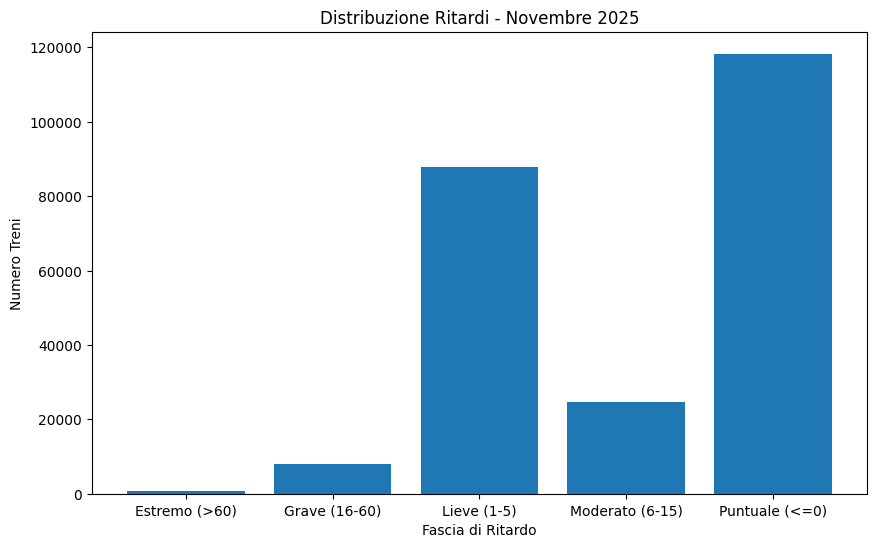

In [119]:
# 5. VISUALIZZAZIONE
plt.figure(figsize=(10, 6))
plt.bar(dati_grafico.index, dati_grafico.values)

plt.title('Distribuzione Ritardi - Novembre 2025')
plt.xlabel('Fascia di Ritardo')
plt.ylabel('Numero Treni')

plt.show()

In [120]:
# 6. ANTEPRIMA DATI
print(df[['Numero treno', 'Ritardo arrivo', 'Fascia_Ritardo']])

        Numero treno  Ritardo arrivo   Fascia_Ritardo
0               3980               4      Lieve (1-5)
1               5206              10  Moderato (6-15)
2               3499              46    Grave (16-60)
3              12620               5      Lieve (1-5)
4               2029              55    Grave (16-60)
...              ...             ...              ...
247641          2989              -2   Puntuale (<=0)
247642           797               0   Puntuale (<=0)
247643           892              -1   Puntuale (<=0)
247644          4693              -5   Puntuale (<=0)
247645           789              -1   Puntuale (<=0)

[239719 rows x 3 columns]


In [121]:
print("numero di treni puntuali:", len(df[df['Fascia_Ritardo'] == 'Puntuale (<=0)']))
print("numero di treni in ritardo lieve (1-5):", len(df[df['Fascia_Ritardo'] == 'Lieve (1-5)']))
print("numero di treni in ritardo moderato (6-15):", len(df[df['Fascia_Ritardo'] == 'Moderato (6-15)']))

numero di treni puntuali: 118293
numero di treni in ritardo lieve (1-5): 87781
numero di treni in ritardo moderato (6-15): 24721


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239719 entries, 0 to 247645
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Categoria                   239719 non-null  object        
 1   Numero treno                239719 non-null  int64         
 2   Codice stazione partenza    239719 non-null  object        
 3   Nome stazione partenza      239719 non-null  object        
 4   Ora partenza programmata    239719 non-null  datetime64[ns]
 5   Ritardo partenza            239719 non-null  int64         
 6   Codice stazione arrivo      239719 non-null  object        
 7   Nome stazione arrivo        239719 non-null  object        
 8   Ora arrivo programmata      239719 non-null  datetime64[ns]
 9   Ritardo arrivo              239719 non-null  int64         
 10  Codice stazione partenza 0  3909 non-null    object        
 11  Nome stazione partenza 0    3929 non-null   

In [123]:
#il nostro dataset ha ora 2 colonne in più:
# "Ritardo_Tratta": indica il ritardo accumulato durante il viaggio
# "Fascia_Ritardo": indica la categoria di ritardo in base ai minuti di ritardo all'arrivo

### Analisi della Correlazione: Partenza vs Arrivo
Prima di passare ai modelli predittivi, visualizziamo la relazione diretta tra il ritardo registrato alla partenza e quello registrato all'arrivo. 

Questo scatter plot ci permette di capire:
* Se esiste una **tendenza lineare** (i punti formano una diagonale).
* Quanto è forte la **dispersione** (i punti lontani dalla diagonale rappresentano i treni che hanno recuperato o accumulato molto ritardo durante il tragitto).

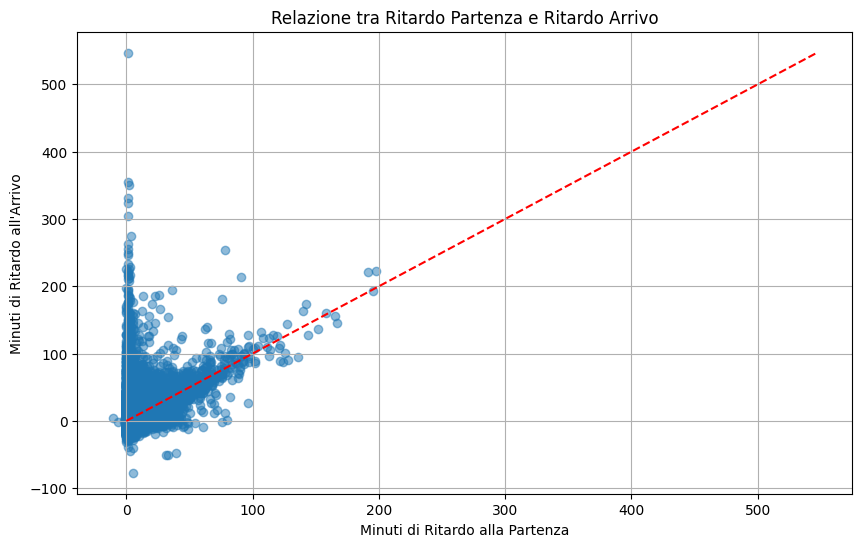

In [124]:
# Cella per Visualizzazione Correlazione

plt.figure(figsize=(10, 6))

# Sull'asse X il ritardo alla partenza, sull'asse Y il ritardo all'arrivo
plt.scatter(df['Ritardo partenza'], df['Ritardo arrivo'], alpha=0.5)

plt.title('Relazione tra Ritardo Partenza e Ritardo Arrivo')
plt.xlabel('Minuti di Ritardo alla Partenza')
plt.ylabel('Minuti di Ritardo all\'Arrivo')
plt.grid(True)

limite_max = max(df['Ritardo partenza'].max(), df['Ritardo arrivo'].max())
plt.plot([0, limite_max], [0, limite_max], color='red', linestyle='--')
plt.show()

**Osservazioni dal grafico:**
Si nota una chiara concentrazione di punti lungo la diagonale, confermando che il ritardo alla partenza è il principale "colpevole" del ritardo finale. Tuttavia, l'ampia nuvola di punti spiega perché il nostro modello di Machine Learning avrà un errore: molti treni riescono a deviare recuperando tempo o subendo ulteriori imprevisti.

----

### Analisi delle tratte

- Creiamo una nuova colonna "tratta" unendo per ogni riga la stazione di partenza e di arrivo, separandole con un -
- Raggruppiamo tutti i vari treni per tratta e calcoliamo la media di ritardo arrivo per oguno
- Ordiamo in ordine decrescente e decretiamo le prime 10 tratte peggiori

IMPORTANTE: consideriamo solo le tratte che hanno avuto ALMENO N treni al mese, per evitare casi isolati di ritardo estemo, salviamo il valore nella variabile "ntreni_mensili_minimi".

--- Top 10 Tratte (Media Ritardo e Numero Treni Analizzati) ---
                                                   mean  count
Tratta                                                        
REGGIO DI CALABRIA CENTRALE - TORINO PORTA NUOVA  24.11    118
NAPOLI CENTRALE - TORINO PORTA NUOVA              19.04    118
SIRACUSA - ROMA TERMINI                           18.84     92
TREVIGLIO - GALLARATE                             17.47     51
VENEZIA S.LUCIA - TORINO PORTA NUOVA              17.39     83
NAPOLI CENTRALE - VENEZIA S.LUCIA                 14.91    160
BARI CENTRALE - MILANO CENTRALE                   14.89    114
SALERNO - TORINO PORTA NUOVA                      14.19    147
ROMA TERMINI - TARANTO                            14.03     59
BRENNERO - BOLOGNA CENTRALE                       13.84    139


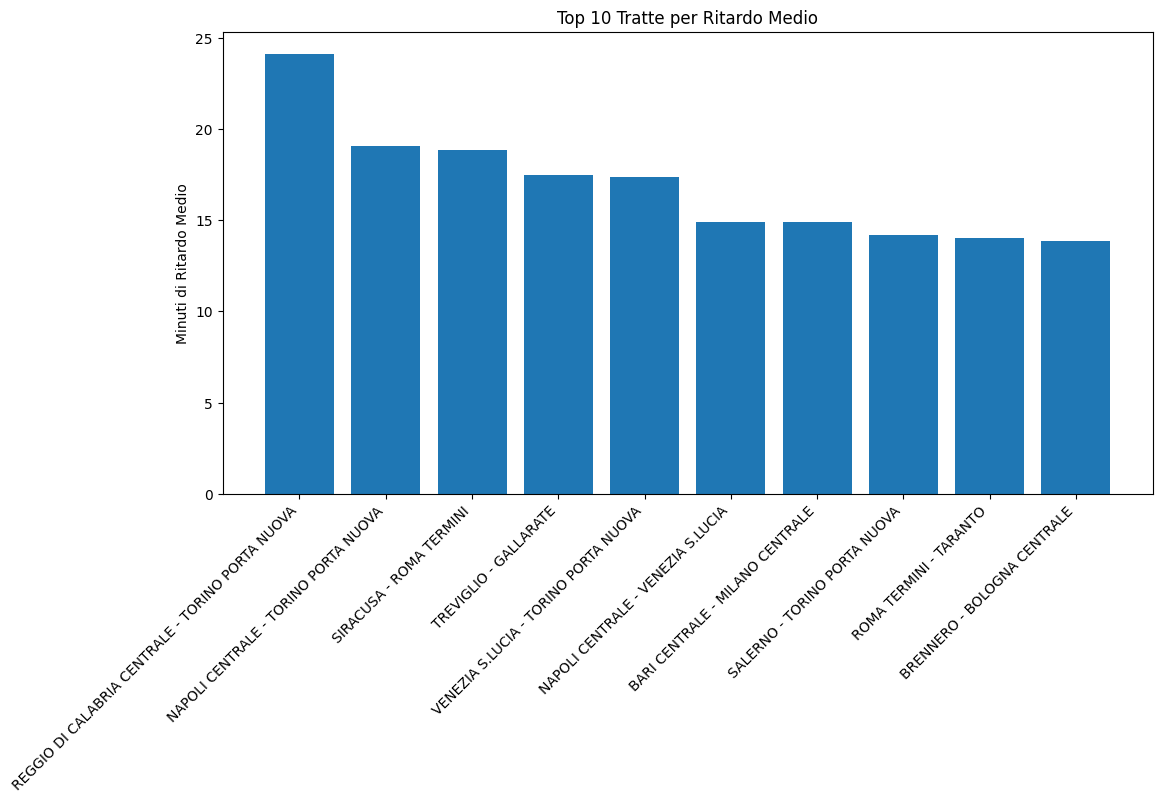

In [125]:
# 1. Creiamo la colonna 'Tratta' unendo le stringhe
df['Tratta'] = df['Nome stazione partenza'] + ' - ' + df['Nome stazione arrivo']

# 2. Raggruppiamo e calcoliamo sia la Media che il Conteggio
tratte_stats = df.groupby('Tratta')['Ritardo arrivo'].agg(['mean', 'count'])

# 3. Consideriamo solo le tratte con almeno N treni al mese (per evitare casi isolati)
ntreni_mensili_minimi = 50
ntreni_mensili_massimi = 200
tratte_significative = tratte_stats[tratte_stats['count'] > ntreni_mensili_minimi]
# tratte_significative_ = tratte_stats[(tratte_stats['count'] > ntreni_mensili_minimi) & (tratte_stats['count'] <= ntreni_mensili_massimi)]

# Ordiniamo e prendiamo le top 10
# Ordiniamo per media e prendiamo gli indici delle migliori 10
top_10_indices = tratte_significative['mean'].sort_values(ascending=False).head(10).index

# Selezioniamo le righe complete (Media + Conteggio) usando quegli indici
risultati_finali = tratte_significative.loc[top_10_indices]

print("--- Top 10 Tratte (Media Ritardo e Numero Treni Analizzati) ---")
# Arrotondiamo a 2 decimali per pulizia
print(risultati_finali.round(2))

# 4. Visualizziamo queste top 10 tratte con un grafico a barre
plt.figure(figsize=(12, 6))
# Per i grafici a barre usiamo l'indice (i nomi delle tratte) come X e i valori come Y
plt.bar(top_10_indices, risultati_finali['mean'].values)

# Ruotiamo le etichette sull'asse X per renderle leggibili (comando standard di matplotlib)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Tratte per Ritardo Medio')
plt.ylabel('Minuti di Ritardo Medio')
plt.show()

Ora andiamo ad analizzare il ritardo medio per ogni categoria di treno

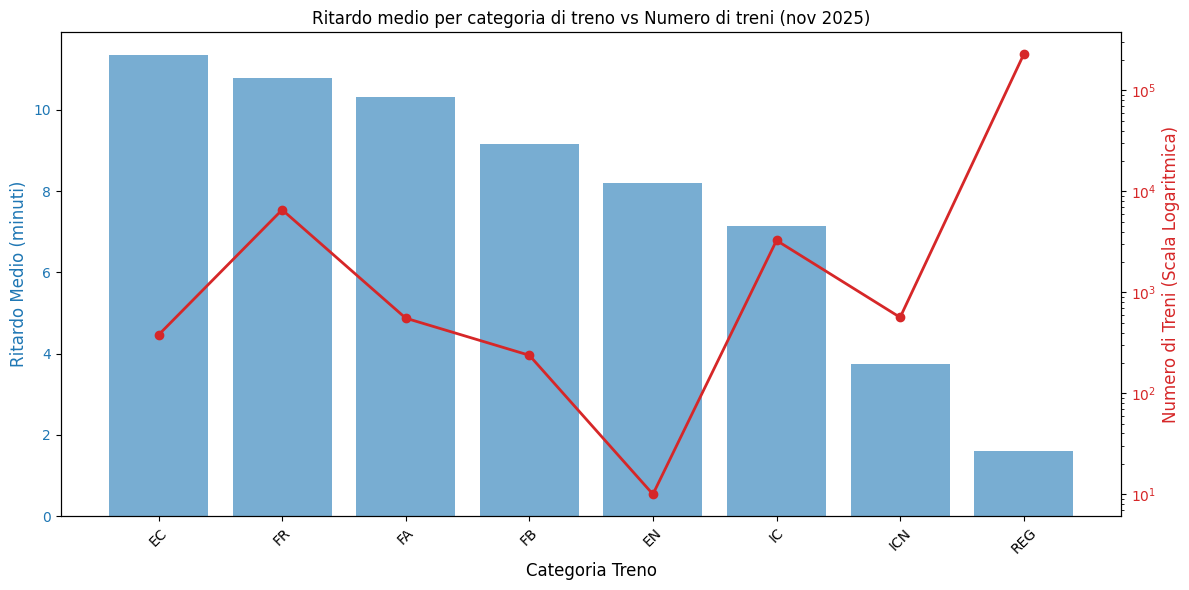

           Numero Treni  Ritardo Medio
Categoria                             
EC                  379      11.343008
FR                 6577      10.777558
FA                  555      10.308108
FB                  238       9.155462
EN                   10       8.200000
IC                 3269       7.148975
ICN                 565       3.753982
REG              228126       1.594698


In [128]:
# 1. Calcoliamo le statistiche aggregate
cat_stats = df.groupby('Categoria')['Ritardo arrivo'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)

# Rinominiamo per chiarezza nel grafico
cat_stats.columns = ['Numero Treni', 'Ritardo Medio']

# 2. Creiamo il grafico a doppio asse
fig, ax1 = plt.subplots(figsize=(12, 6))

# ASSE SINISTRO (Barre): Ritardo Medio
# Questo risponde alla tua domanda: "Chi è più in ritardo MEDIAMENTE?"
color = 'tab:blue'
ax1.set_xlabel('Categoria Treno', fontsize=12)
ax1.set_ylabel('Ritardo Medio (minuti)', color=color, fontsize=12)
ax1.bar(cat_stats.index, cat_stats['Ritardo Medio'], color=color, alpha=0.6, label='Ritardo Medio')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# ASSE DESTRO (Linea): Numero di Treni
# Questo mostra il volume e conferma che i REG sono tantissimi
ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Numero di Treni (Scala Logaritmica)', color=color, fontsize=12)
ax2.plot(cat_stats.index, cat_stats['Numero Treni'], color=color, marker='o', linewidth=2, label='Numero Treni')
ax2.tick_params(axis='y', labelcolor=color)

# Usiamo la scala logaritmica per l'asse destro perché i Regionali sono
# sproporzionatamente più numerosi 
ax2.set_yscale('log')

plt.title("Ritardo medio per categoria di treno vs Numero di treni (nov 2025)")
fig.tight_layout()
plt.show()

# Stampiamo anche i numeri esatti
print(cat_stats)

- possiamo notare un paradosso dei treni regionali: nonostante rappresentino la maggior parte del traffico (oltre 200k treni), presentano il piu basso ritardo medio tra tutte le categorie, forse in parte dovuto alle brevi tratte

- un altro dato interessante sono i treni InterCity (IC), a parità di volumi e lunghezze delle tratte quasi pari ai frecciarossa (FR) ma con un ritardo medio più basso


---

### Analisi delle Criticità Geografiche
ora analizziamo le stazioni di partenza per identificare le principali cittè critiche della rete.
Vengono filtrate le stazioni con basso traffico (meno di 100 treni/mese) per evitare che piccoli ritardi su tratte secondarie influenzino la media.

L'obiettivo è rispondere alla domanda: **Quali sono le stazioni da cui i treni partono con maggior ritardo?**

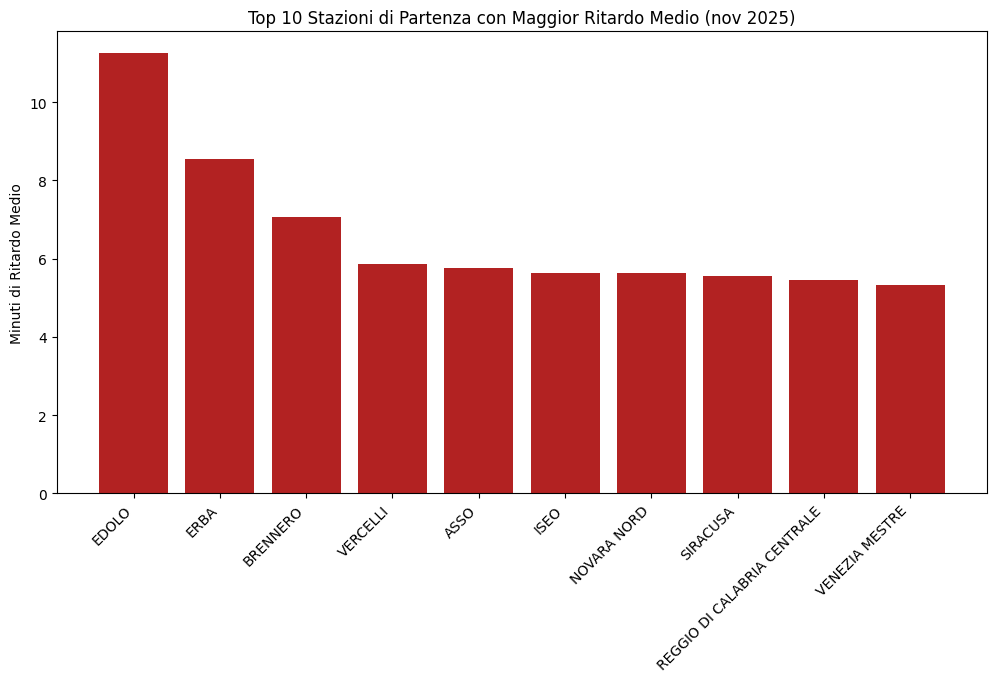

In [129]:
# Cella: Ritardo medio per stazione di partenza
# Raggruppiamo per stazione di partenza e calcoliamo la media del ritardo
# Filtriamo solo le stazioni con almeno 100 treni partiti nel mese per evitare stazioni "fantasma"
stats_stazioni = df.groupby('Nome stazione partenza').agg(
    Media_Ritardo=('Ritardo arrivo', 'mean'),
    Numero_Treni=('Numero treno', 'count')
)

# Prendiamo solo stazioni rilevanti (> 100 treni)
stats_stazioni = stats_stazioni[stats_stazioni['Numero_Treni'] > 100]

# Ordiniamo e prendiamo le peggiori 10
top_10 = stats_stazioni.sort_values(by='Media_Ritardo', ascending=False).head(10)

# Visualizzazione
plt.figure(figsize=(12, 6))
plt.bar(top_10.index, top_10['Media_Ritardo'], color='firebrick')
plt.title('Top 10 Stazioni di Partenza con Maggior Ritardo Medio (nov 2025)')
plt.ylabel('Minuti di Ritardo Medio')
plt.xticks(rotation=45, ha='right')
plt.show()

In [130]:
print("N treni che partono da EDOLO:", (df["Nome stazione partenza"] == "EDOLO").sum())

N treni che partono da EDOLO: 364


notiamo che la maggior parte delle città nella classifica si trovano nel nord Italia, e possiedono stazioni in zone montuose con difficile percorrenza, anche dovuta spesso a un binario unico. Queste zone sono quasi interamnete gestite dall'operatore ferroviario Trenord

---

## Machine Learning


--- Risultati del Modello Predittivo ---
Coefficiente (Pendenza): 0.83
Intercetta: -0.16
R-Squared (Affidabilità): 0.1280
FORMULA MODELLO: Ritardo_Arrivo = 0.83 * Ritardo_Partenza + -0.16


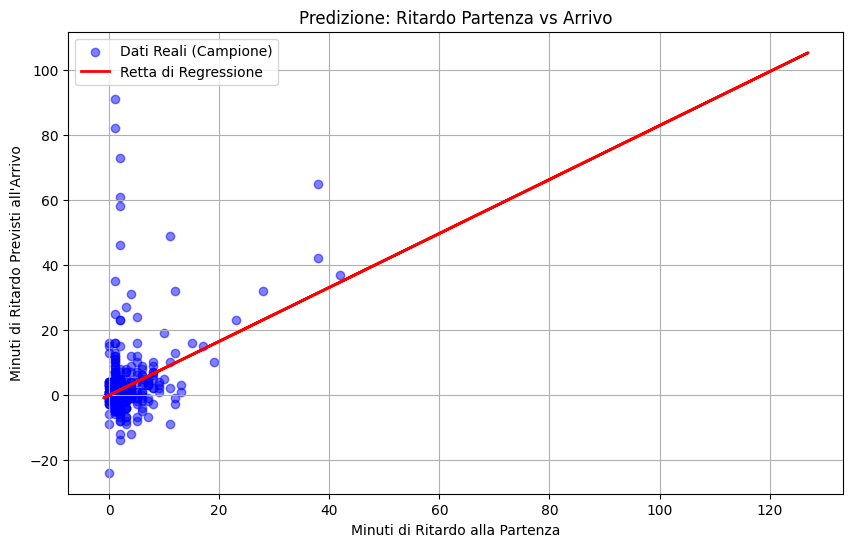

In [131]:
# --- 1. PREPARAZIONE DEI DATI ---
# Selezioniamo le variabili:
# X (Input) = Ritardo alla Partenza (causa)
# y (Target) = Ritardo all'Arrivo (effetto)
# .reshape(-1, 1) serve perché sklearn si aspetta una matrice per la X
X = df['Ritardo partenza'].values.reshape(-1, 1) #causa
y = df['Ritardo arrivo'].values #effetto

# --- 2. DIVISIONE TRAIN/TEST ---
# Dividiamo i dati: 80% per addestrare (train), 20% per testare (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. ADDESTRAMENTO DEL MODELLO ---
# Creiamo il modello vuoto e lo "alleniamo" sui dati di train
model = LinearRegression()
model.fit(X_train, y_train)

# --- 4. PREDIZIONE E VALUTAZIONE ---
# Usiamo il modello addestrato per fare previsioni sui dati di test
y_pred = model.predict(X_test)

# Estraiamo i parametri matematici della retta
coefficiente = model.coef_[0]  # Pendenza
intercetta = model.intercept_  # Punto di partenza sull'asse Y
r2 = r2_score(y_test, y_pred)  # Indice di affidabilità (da 0 a 1)

print(f"--- Risultati del Modello Predittivo ---")
print(f"Coefficiente (Pendenza): {coefficiente:.2f}")
print(f"Intercetta: {intercetta:.2f}")
print(f"R-Squared (Affidabilità): {r2:.4f}")
print(f"FORMULA MODELLO: Ritardo_Arrivo = {coefficiente:.2f} * Ritardo_Partenza + {intercetta:.2f}")


# --- 5. VISUALIZZAZIONE DELLA REGRESSIONE ---
plt.figure(figsize=(10, 6))

# Disegniamo i punti reali (solo un campione di 500 per chiarezza)
plt.scatter(X_test[:500], y_test[:500], color='blue', alpha=0.5, label='Dati Reali (Campione)')

# Disegniamo la retta rossa prevista dal modello
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Retta di Regressione')

plt.title('Predizione: Ritardo Partenza vs Arrivo')
plt.xlabel('Minuti di Ritardo alla Partenza')
plt.ylabel('Minuti di Ritardo Previsti all\'Arrivo')
plt.legend()
plt.grid(True)
plt.show()

il modello assume che il viaggio sia lineare, ma sappiamo che nella realtà ferroviaria intervengono variabili esterne (guasti, precedenze) che rendono i punti dispersi nel grafico.

### Spiegazione dei risultati:
- Coefficiente (Pendenza): 0.83 -> Per ogni minuto di ritardo alla partenza, il treno ne porta all'arrivo solo 0.83.
- Intercetta: -0.16 -> Se un treno partisse con con 0 minuti di ritardo (quindi puntuale), il modello prevede che arrivi con -0.16 minuti (cioè in anticipo). Questo dato ci dice che gli orari ufficiali sono calcolati bene, se non si verificano imprevisti durante il viaggio
- R-Squared (Affidabilità): 0.1280 -> Questo dato così basso ci spiega che il ritardo all'arrivo è dovuto solo al 12% circa del ritardo in partenza. Significa che l'87% del ritardo finale dipende da cose che succedono DURANTE il viaggio (guasti, precedenze, ecc). Non è possibile prevedere con certezza l'arrivo guardando solo la partenza


In [132]:
#testing della formula fornita dal modello
def prevedi_ritardo_arrivo(ritardo_partenza):
    return coefficiente * ritardo_partenza + intercetta

print(prevedi_ritardo_arrivo(60))

49.65389996204185


in media, su un ritardo di 60 minuti in partenza, il ritardo di arrivo sarà circa 50 minuti -> Il treno ha recuperato 10 minuti di ritardo durante la tratta

---

## 4. Modellazione Predittiva (Machine Learning)

Dopo l'analisi esplorativa, utilizziamo un modello di **Regressione Lineare Multipla** per tentare di prevedere il ritardo all'arrivo.

* **Variabili di Input (X):** Ritardo alla partenza, Ora di partenza, Stazione di partenza.
* **Variabile Target (y):** Ritardo all'arrivo.

Poiché i nomi delle stazioni sono dati testuali, utilizziamo la tecnica del **One Hot Encoding** per trasformarli in valori numerici comprensibili dall'algoritmo. L'affidabilità del modello viene valutata tramite il coefficiente **R-Squared**.

--- Risultati Regressione Multipla (Ritardo + Ora + Stazione) ---
R-Squared (Affidabilità): 0.1556


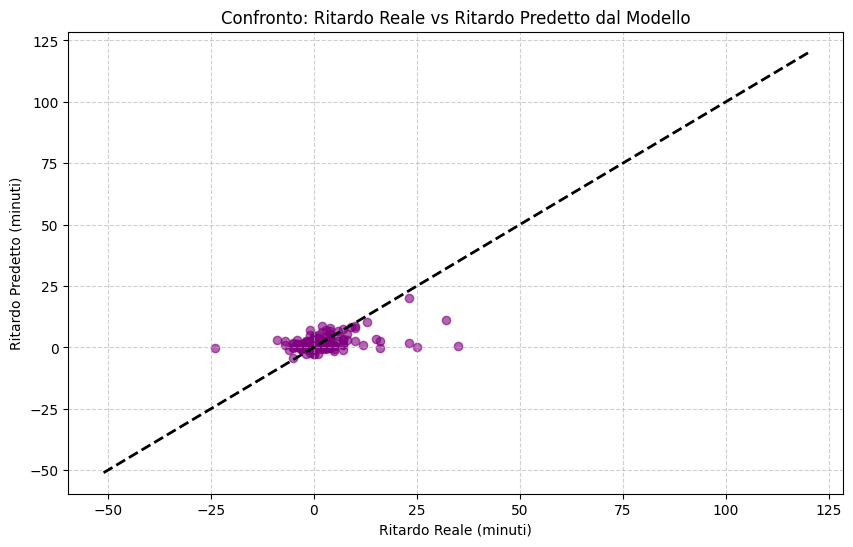

In [133]:
# --- 1. PREPARAZIONE DELLE VARIABILI (FEATURE ENGINEERING) ---

# Estraiamo l'ora come numero (0-23) perché il modello non capisce le date complete
df['Ora_Partenza_Num'] = df['Ora partenza programmata'].dt.hour

# Selezioniamo le 3 variabili di input richieste dalla tua domanda
# 1. Ritardo accumulato (Numerico)
# 2. Orario (Numerico)
# 3. Stazione di partenza (Testo -> Da convertire)
features = ['Ritardo partenza', 'Ora_Partenza_Num', 'Nome stazione partenza']

X = df[features]       # Matrice di Input (Più colonne)
y = df['Ritardo arrivo'] # Target (Quello che vogliamo prevedere)

# --- 2. TRASFORMAZIONE DEI DATI (ONE HOT ENCODING) ---
# Usiamo ColumnTransformer come nel file 'one_hot_encoding.ipynb'
# Trasformiamo la colonna 'Nome stazione partenza' in numeri (0/1)
# 'passthrough' significa: "lascia le altre colonne (ritardo e ora) così come sono"
ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(sparse_output=True, handle_unknown='ignore'), ['Nome stazione partenza'])
    ],
    remainder='passthrough'
)

# Applichiamo la trasformazione
X_transformed = ct.fit_transform(X)

# --- 3. DIVISIONE TRAIN/TEST ---
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# --- 4. ADDESTRAMENTO (REGRESSIONE MULTIPLA) ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- 5. VALUTAZIONE ---
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"--- Risultati Regressione Multipla (Ritardo + Ora + Stazione) ---")
print(f"R-Squared (Affidabilità): {r2:.4f}")

# --- 6. VISUALIZZAZIONE (REALE vs PREDETTO) ---
# Non possiamo disegnare una retta 2D perché abbiamo troppe variabili,
# ma possiamo confrontare i valori reali con quelli predetti
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:200], y_pred[:200], alpha=0.6, color='purple')
plt.plot([y_test.min(), 120], [y_test.min(), 120], 'k--', lw=2) # Linea ideale perfetta
plt.title('Confronto: Ritardo Reale vs Ritardo Predetto dal Modello')
plt.xlabel('Ritardo Reale (minuti)')
plt.ylabel('Ritardo Predetto (minuti)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Il modello di Regressione Multipla ha ottenuto un R^2 score di 0.1556. 
Questo risulato indica una bassa correlazione lineare: conoscere l'orario e il ritardo alla partenza non è sufficiente per prevedere con precisione il ritardo all'arrivo.
Questo fenomeno dimostra che la maggior parte del ritardo (85%) viene accumulata durante il viaggio a causa di fattori dinamici (traffico, guasti, interferenze tra treni) che non sono presenti nelle variabili di input statiche.


Addestramento Classificatore in corso...

--- Risultati Classificazione ---
Accuratezza del Modello: 55.89%

Report Dettagliato:
                 precision    recall  f1-score   support

  Estremo (>60)       0.42      0.11      0.17       183
  Grave (16-60)       0.46      0.21      0.28      1609
    Lieve (1-5)       0.50      0.46      0.48     17506
Moderato (6-15)       0.36      0.14      0.20      4963
 Puntuale (<=0)       0.61      0.74      0.67     23683

       accuracy                           0.56     47944
      macro avg       0.47      0.33      0.36     47944
   weighted avg       0.54      0.56      0.54     47944



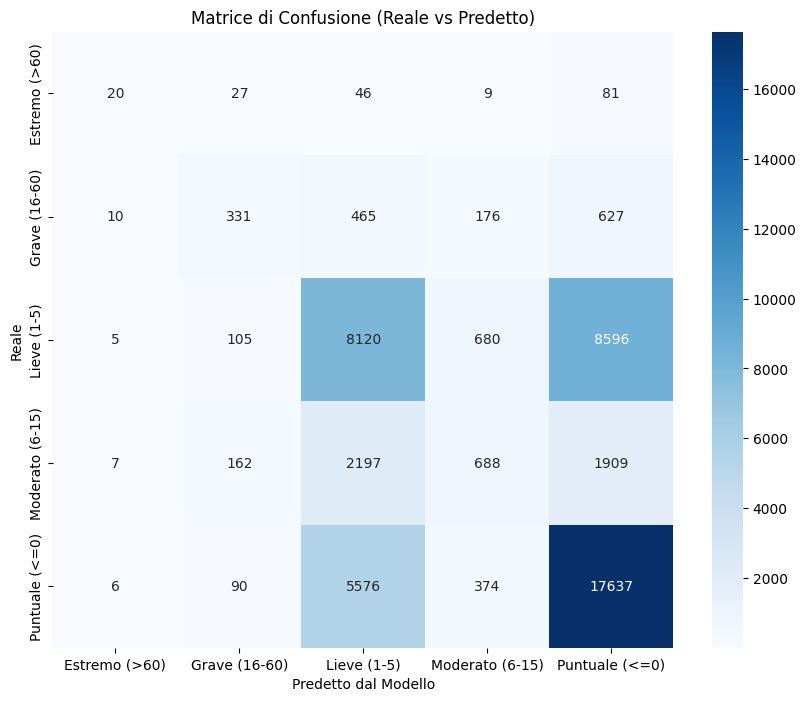

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# --- 5. PIANO B: CLASSIFICAZIONE ---
# Visto che prevedere il minuto esatto è difficile (R2 basso),
# proviamo a prevedere la "Fascia di Ritardo" (Classe).

# Usiamo le stesse variabili di input (X), ma cambiamo il target (y)
# y_class ora contiene le categorie: "Puntuale", "Lieve", "Grave", ecc.
y_class = df['Fascia_Ritardo']

# Rieseguiamo la trasformazione e divisione dati per il nuovo target
X_transformed = ct.fit_transform(df[['Ritardo partenza', 'Ora_Partenza_Num', 'Nome stazione partenza']])
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_transformed, y_class, test_size=0.2, random_state=42)

# Addestriamo un Classificatore Random Forest
print("Addestramento Classificatore in corso...")
clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf.fit(X_train_c, y_train_c)

# Predizione
y_pred_class = clf.predict(X_test_c)

# Valutazione
accuracy = accuracy_score(y_test_c, y_pred_class)
print(f"\n--- Risultati Classificazione ---")
print(f"Accuratezza del Modello: {accuracy:.2%}") # Es. 85.00%
print("\nReport Dettagliato:")
print(classification_report(y_test_c, y_pred_class))

# Matrice di Confusione (Grafico)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_c, y_pred_class, labels=clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Matrice di Confusione (Reale vs Predetto)')
plt.xlabel('Predetto dal Modello')
plt.ylabel('Reale')
plt.show()

## Conclusioni e Risultati Chiave

Al termine dell'analisi, possiamo sintetizzare tre "verità" sui dati ferroviari di Novembre 2025:

1. **Il Ritardo è Dinamico, non Statico:**
   Il modello di regressione ci dice che il ritardo alla partenza non è una condanna. Il sistema ha un'elasticità che permette di recuperare circa il **17%** del tempo perso in partenza (coefficiente 0.83), salvo imprevisti gravi lungo la linea.

2. **La Fragilità dell'Alta Velocità:**
   Contrariamente alle aspettative, le Frecce e gli Intercity soffrono di più rispetto ai Regionali su certe direttrici. Questo suggerisce che la rete AV lavora al limite della saturazione: basta un piccolo intoppo per generare ritardi a catena, mentre il traffico regionale frammentato è più resiliente.

3. **Geografia del Disagio:**
   La mappa dei ritardi non segue la latitudine Nord-Sud, ma l'**orografia**. Le tratte alpine e prealpine soffrono sistematicamente di più rispetto alle tratte di pianura, evidenziando la necessità di interventi infrastrutturali specifici in quelle aree.

---
**Next Steps:**
L'attuale modello predittivo spiega il 13% della varianza. Per superare questa soglia, sarebbe necessario integrare variabili esogene come **Meteo**, **Manutenzioni Programmate**, **Scioperi**, **Guasti alla linea**, ecc..